In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import seaborn as sns
import tikzplotlib
from IPython.display import display, HTML
sns.set()
import scipy.stats

In [2]:
def match_architecture_checkpoint(base_architecture, pretrained_checkpoint):
    situations = {
        ('DistilbertCls', 'distilbert-base-cased'): 'DistilBERTCls',
        ('DistilbertMean', 'distilbert-base-cased'): 'DistilBERTMean',
        ('DistilbertLastNCls', 'distilbert-base-cased'): 'DistilBERTNCls',
        ('RobertaCls', 'distilroberta-base'): 'DistilRoBERTaCls',
        ('RobertaMean', 'distilroberta-base'): 'DistilRoBERTaMean',
        ('RobertaLastNCls', 'distilroberta-base'): 'DistilRoBERTaNCls',
    }
    return situations[(base_architecture, pretrained_checkpoint)]


def match_architecture_checkpoint_detailed(base_architecture, pretrained_checkpoint):
    situations = {
        ('DistilbertCls', 'distilbert-base-cased'): ('DistilBERT', 'Cls'),
        ('DistilbertMean', 'distilbert-base-cased'):('DistilBERT', 'Mean'),
        ('DistilbertLastNCls', 'distilbert-base-cased'): ('DistilBERT', 'LastNCls'),
        ('RobertaCls', 'distilroberta-base'): ('DistilRoBERTa', 'Cls'),
        ('RobertaMean', 'distilroberta-base'): ('DistilRoBERTa', 'Mean'),
        ('RobertaLastNCls', 'distilroberta-base'): ('DistilRoBERTa', 'LastNCls')
    }
    return situations[(base_architecture, pretrained_checkpoint)]


def create_model_name(base_architecture, pretrained_checkpoint, one_two_tower):
    return f'{match_architecture_checkpoint(base_architecture, pretrained_checkpoint)} {one_two_tower}'

def match_dataset_name_and_optional_epochs(dataset_raw_name):
    datasets = {
        'M_chunked_by_blocks_min3_max10': ('IGNORE', 4),
        'M_basic_chunked_10': ('HDFS1-blocks', 4),
        'M_time_ordered_chunked_10': ('HDFS1-time', 4),
        'no_timestamps_train-data-HDFS1-cv1-1-time-ordered': ('HDFS1-time', None),
        'Combined_20210401_concat-to-max_epochs-5_seed-43': ('Mix Concat', 5),
        'Combined_20210401_concat-to-max_epochs-3_seed-43': ('Mix Concat', 3),
        'Combined_20210401_smart-average_epochs-5_seed-43': ('Mix SmartAvg', 5),
        'Combined_20210401_smart-average_epochs-3_seed-43': ('Mix SmartAvg', 3),
    }
    return datasets[dataset_raw_name]


def parse_run_name(name):
    if 'fasttext' in name:
        model_name = 'fastText'
        dataset_raw_name = name.split('AETCN_using_fasttext_from_', 1)[1]
    else:
        simplified_name = name.split('AETCN_using_LogEncoder_from_', 1)[1].split('_Seed-42', 1)[0].replace('_roberta', '').replace('_Eps_1', '')
        if simplified_name[0].isdigit(): # Old results for DistilbertCls from distilbert-base-cased
            structured = ['DistilbertCls', 'distilbert-base-cased'] + simplified_name.split('_', 1)
        else:
            structured = simplified_name.split('_', 3)
        model_name = create_model_name(*structured[:3])
        dataset_raw_name = structured[3]
    dataset_name, epochs = match_dataset_name_and_optional_epochs(dataset_raw_name)
    if epochs is not None:
        model_name = model_name + f' {epochs} epochs'
    return {'model': model_name, 'dataset': dataset_name}

def parse_run_name_detailed(name):
    if 'fasttext' in name:
        model_type = 'fastText'
        embed_type = 'fastText'
        epochs = None
        towers = None
        dataset_raw_name = name.split('AETCN_using_fasttext_from_', 1)[1]
    else:
        simplified_name = name.split('AETCN_using_LogEncoder_from_', 1)[1].split('_Seed-42', 1)[0].replace('_roberta', '').replace('_Eps_1', '')
        if simplified_name[0].isdigit(): # Old results for DistilbertCls from distilbert-base-cased
            structured = ['DistilbertCls', 'distilbert-base-cased'] + simplified_name.split('_', 1)
        else:
            structured = simplified_name.split('_', 3)
        model_type, embed_type = match_architecture_checkpoint_detailed(*structured[:2])
        towers = structured[2]
        dataset_raw_name = structured[3]
    dataset_name, epochs = match_dataset_name_and_optional_epochs(dataset_raw_name)
    return {'model_type': model_type, 'embedding_type': embed_type, 'towers': towers, 'epochs': epochs, 'dataset': dataset_name}

In [3]:
result_path = Path('/home/cernypro/dev/source/ml4logs/models/anomaly_detection')

In [4]:
results = []
for res_file in result_path.glob('*/run_info.json'):
    with res_file.open(mode='r') as f:
        cur_res_json = json.load(f)
    run_name = cur_res_json['run_name']
    cur_res = {
        'run_name' : run_name,
        'precision': cur_res_json['report_test_using_val']['precision'],
        'recall': cur_res_json['report_test_using_val']['recall'],
        'f1_score': cur_res_json['report_test_using_val']['f1_score'],
        'mcc_score': cur_res_json['report_test_using_val']['mcc_score']
    }
    results.append(cur_res)

In [5]:
to_df = [{**parse_run_name(cur['run_name']), **cur} for cur in results]
to_df = [cur for cur in to_df if cur['dataset'] != 'IGNORE']

In [6]:
df = pd.DataFrame(to_df).drop('run_name', axis=1)

In [7]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    display(df.sort_values(by=['dataset', 'model']))

,model,dataset,precision,recall,f1_score,mcc_score
13,DistilBERTCls 1T 4 epochs,HDFS1-blocks,0.980085,0.409145,0.577294,0.627367
3,DistilBERTCls 2T 4 epochs,HDFS1-blocks,0.791630,0.539192,0.641469,0.645048
44,DistilBERTMean 1T 4 epochs,HDFS1-blocks,0.974684,0.411520,0.578706,0.627386
37,DistilBERTMean 2T 4 epochs,HDFS1-blocks,0.975989,0.410333,0.577759,0.626909
53,DistilBERTNCls 1T 4 epochs,HDFS1-blocks,0.978541,0.406176,0.574066,0.624541
21,DistilBERTNCls 2T 4 epochs,HDFS1-blocks,0.953652,0.403207,0.566778,0.613865
67,DistilRoBERTaCls 1T 4 epochs,HDFS1-blocks,1.000000,0.362233,0.531822,0.596150
32,DistilRoBERTaCls 2T 4 epochs,HDFS1-blocks,0.995138,0.364608,0.533681,0.596595
9,DistilRoBERTaMean 1T 4 epochs,HDFS1-blocks,0.581109,0.672209,0.623348,0.612861
50,DistilRoBERTaMean 2T 4 epochs,HDFS1-blocks,1.000000,0.362233,0.531822,0.596150


In [8]:
df_csv = df.sort_values(by=['f1_score'], ascending=False).reset_index(drop=True)
# df_csv['index'] += 1
# df_csv.to_csv('/home/cernypro/dev/source/ml4logs/docs/exp_res_f1.csv', float_format='%.4f', index=False)
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    display(df_csv)

,model,dataset,precision,recall,f1_score,mcc_score
0,fastText,HDFS1-time,0.776847,0.936461,0.849219,0.848170
1,DistilBERTCls 1T 3 epochs,Mix Concat,0.888231,0.712589,0.790774,0.790204
2,DistilBERTMean 1T 3 epochs,Mix SmartAvg,0.902613,0.676960,0.773668,0.776220
3,DistilBERTCls 2T 4 epochs,HDFS1-time,0.741794,0.805226,0.772210,0.765732
4,DistilBERTCls 1T 3 epochs,Mix SmartAvg,0.860380,0.698931,0.771298,0.769494
5,DistilBERTMean 1T 5 epochs,Mix SmartAvg,0.897233,0.673990,0.769752,0.772063
6,DistilBERTCls 2T 3 epochs,Mix SmartAvg,0.875483,0.672209,0.760497,0.761190
7,DistilBERTCls 1T 5 epochs,Mix SmartAvg,0.874710,0.671615,0.759825,0.760494
8,DistilBERTMean 1T 5 epochs,Mix Concat,0.882212,0.653800,0.751023,0.753471
9,DistilBERTMean 2T 3 epochs,Mix SmartAvg,0.856816,0.668052,0.750751,0.750267


In [9]:
'RobertaCls_distilroberta-base_1T_Combined_20210401_concat-to-max_epochs-3_seed-43'.split('_', 3)

['RobertaCls',
 'distilroberta-base',
 '1T',
 'Combined_20210401_concat-to-max_epochs-3_seed-43']

In [10]:
parse_run_name_detailed('AETCN_using_LogEncoder_from_2T_Eps_1_M_basic_chunked_10_Seed-42_T-len_512_C-len_512_Tr-batch_64_Ev-b_64_O-dim_100')

{'model_type': 'DistilBERT',
 'embedding_type': 'Cls',
 'towers': '2T',
 'epochs': 4,
 'dataset': 'HDFS1-blocks'}

In [11]:
to_df2 = [{**parse_run_name_detailed(cur['run_name']), **cur} for cur in results]
to_df2 = [cur for cur in to_df2 if cur['dataset'] != 'IGNORE']
df2 = pd.DataFrame(to_df2).drop('run_name', axis=1)
df2.insert(0, 'ranking', df2['f1_score'].rank(method='first', ascending=False).astype(int))
df2['percentage_of_best'] = df2['f1_score']/df2['f1_score'].max()
df2['ds_type'] = np.where(df2['dataset'].str.startswith('HDFS1'), 'HDFS1', 'Mix')

In [12]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 15):
    tmp_df = df2.copy()
    tmp_df['dataset'] = '\makecell[l]{' + df2['dataset'].str.replace(' ', '\\\\ ').str.replace('-', '\\\\ ') + '}'
    display(HTML(tmp_df.sort_values(by=['f1_score'], ascending=False)[['dataset']].to_html(index=False)))

dataset
\makecell[l]{HDFS1\\ time}
\makecell[l]{Mix\\ Concat}
\makecell[l]{Mix\\ SmartAvg}
\makecell[l]{HDFS1\\ time}
\makecell[l]{Mix\\ SmartAvg}
\makecell[l]{Mix\\ SmartAvg}
\makecell[l]{Mix\\ SmartAvg}
\makecell[l]{Mix\\ SmartAvg}
\makecell[l]{Mix\\ Concat}
\makecell[l]{Mix\\ SmartAvg}


In [13]:
df2['dataset'].str.replace(' ', '\\\\').str.replace('-', '\\\\')

0     Mix\\SmartAvg
1     Mix\\SmartAvg
2     Mix\\SmartAvg
3     HDFS1\\blocks
4     Mix\\SmartAvg
          ...      
68    Mix\\SmartAvg
69    Mix\\SmartAvg
70    Mix\\SmartAvg
71    Mix\\SmartAvg
72      HDFS1\\time
Name: dataset, Length: 73, dtype: object

In [14]:
df2.sort_values(by=['f1_score'], ascending=False).groupby(['model_type', 'embedding_type','towers']).filter(lambda x: len(x) > 1)
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    display(
        df2
        .sort_values(by=['f1_score'], ascending=False)
        .groupby(['model_type', 'embedding_type', 'towers'])
        .filter(lambda x: len(x) > 1)
        .groupby(['model_type', 'embedding_type', 'towers'])
        .mean().sort_values(by=['f1_score'], ascending=False)
    )

ranking  epochs  precision    recall  \
model_type    embedding_type towers                                           
DistilBERT    Cls            2T      18.500000     4.0   0.826859  0.641825   
                             1T      20.500000     4.0   0.879688  0.616587   
              Mean           1T      18.833333     4.0   0.882943  0.613717   
                             2T      24.666667     4.0   0.866310  0.581255   
              LastNCls       1T      31.166667     4.0   0.880941  0.546912   
                             2T      33.500000     4.0   0.879095  0.540479   
DistilRoBERTa Cls            2T      42.666667     4.0   0.846195  0.516528   
              LastNCls       1T      49.166667     4.0   0.767418  0.539390   
              Mean           2T      48.500000     4.0   0.839299  0.492181   
              LastNCls       2T      53.333333     4.0   0.859219  0.471595   
              Cls            1T      54.000000     4.0   0.802922  0.486837   
              Mean           1T      55.166667     4.0   0.731257  0.520289   

                                     f1_score  mcc_score  percentage_of_best  
model_type    embedding_type towers                                           
DistilBERT    Cls            2T      0.717728   0.719000            0.845162  
                             1T      0.717043   0.725868            0.844356  
              Mean           1T      0.717033   0.725983            0.844344  
                             2T      0.689099   0.699194            0.811451  
              LastNCls       1T      0.669694   0.684473            0.788599  
                             2T      0.664738   0.679885            0.782764  
DistilRoBERTa Cls            2T      0.630648   0.647484            0.742621  
              LastNCls       1T      0.617222   0.625725            0.726812  
              Mean           2T      0.610264   0.629163            0.718618  
              LastNCls       2T      0.600359   0.624185            0.706954  
              Cls            1T      0.595256   0.610682            0.700945  
              Mean           1T      0.594193   0.600000            0.699693

In [15]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 15):
    display(df2.sort_values(by=['model_type', 'embedding_type', 'towers', 'epochs'], ascending=[False, True, True, True]))

,ranking,model_type,embedding_type,towers,epochs,dataset,precision,recall,f1_score,mcc_score,percentage_of_best,ds_type
54,1,fastText,fastText,None,NaN,HDFS1-time,0.776847,0.936461,0.849219,0.848170,1.000000,HDFS1
25,45,DistilRoBERTa,Cls,1T,3.0,Mix Concat,0.760851,0.530879,0.625393,0.626670,0.736434,Mix
28,39,DistilRoBERTa,Cls,1T,3.0,Mix SmartAvg,0.698468,0.595606,0.642949,0.635180,0.757106,Mix
14,66,DistilRoBERTa,Cls,1T,4.0,HDFS1-time,0.818080,0.435273,0.568217,0.588589,0.669105,HDFS1
67,73,DistilRoBERTa,Cls,1T,4.0,HDFS1-blocks,1.000000,0.362233,0.531822,0.596150,0.626248,HDFS1
61,48,DistilRoBERTa,Cls,1T,5.0,Mix Concat,0.706802,0.536817,0.610192,0.606071,0.718533,Mix
65,53,DistilRoBERTa,Cls,1T,5.0,Mix SmartAvg,0.833333,0.460214,0.592961,0.611431,0.698243,Mix
49,26,DistilRoBERTa,Cls,2T,3.0,Mix SmartAvg,0.844753,0.578385,0.686641,0.691836,0.808555,Mix
62,25,DistilRoBERTa,Cls,2T,3.0,Mix Concat,0.805887,0.601544,0.688881,0.688571,0.811194,Mix
7,55,DistilRoBERTa,Cls,2T,4.0,HDFS1-time,0.917929,0.431710,0.587237,0.622853,0.691503,HDFS1


In [16]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 15):
    display(df2[~df2['dataset'].str.startswith('HDFS')].sort_values(by=['f1_score'], ascending=False))

,ranking,model_type,embedding_type,towers,epochs,dataset,precision,recall,f1_score,mcc_score,percentage_of_best,ds_type
11,2,DistilBERT,Cls,1T,3.0,Mix Concat,0.888231,0.712589,0.790774,0.790204,0.931178,Mix
60,3,DistilBERT,Mean,1T,3.0,Mix SmartAvg,0.902613,0.676960,0.773668,0.776220,0.911035,Mix
19,5,DistilBERT,Cls,1T,3.0,Mix SmartAvg,0.860380,0.698931,0.771298,0.769494,0.908243,Mix
71,6,DistilBERT,Mean,1T,5.0,Mix SmartAvg,0.897233,0.673990,0.769752,0.772063,0.906424,Mix
48,7,DistilBERT,Cls,2T,3.0,Mix SmartAvg,0.875483,0.672209,0.760497,0.761190,0.895525,Mix
29,8,DistilBERT,Cls,1T,5.0,Mix SmartAvg,0.874710,0.671615,0.759825,0.760494,0.894734,Mix
57,9,DistilBERT,Mean,1T,5.0,Mix Concat,0.882212,0.653800,0.751023,0.753471,0.884369,Mix
69,10,DistilBERT,Mean,2T,3.0,Mix SmartAvg,0.856816,0.668052,0.750751,0.750267,0.884048,Mix
10,11,DistilBERT,Cls,1T,5.0,Mix Concat,0.892003,0.642518,0.746980,0.751125,0.879608,Mix
36,12,DistilBERT,Mean,1T,3.0,Mix Concat,0.860979,0.647268,0.738983,0.740113,0.870191,Mix


In [17]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 15):
    display(df2.sort_values(by=['f1_score'], ascending=False).reset_index(drop=True))

,ranking,model_type,embedding_type,towers,epochs,dataset,precision,recall,f1_score,mcc_score,percentage_of_best,ds_type
0,1,fastText,fastText,None,NaN,HDFS1-time,0.776847,0.936461,0.849219,0.848170,1.000000,HDFS1
1,2,DistilBERT,Cls,1T,3.0,Mix Concat,0.888231,0.712589,0.790774,0.790204,0.931178,Mix
2,3,DistilBERT,Mean,1T,3.0,Mix SmartAvg,0.902613,0.676960,0.773668,0.776220,0.911035,Mix
3,4,DistilBERT,Cls,2T,4.0,HDFS1-time,0.741794,0.805226,0.772210,0.765732,0.909317,HDFS1
4,5,DistilBERT,Cls,1T,3.0,Mix SmartAvg,0.860380,0.698931,0.771298,0.769494,0.908243,Mix
5,6,DistilBERT,Mean,1T,5.0,Mix SmartAvg,0.897233,0.673990,0.769752,0.772063,0.906424,Mix
6,7,DistilBERT,Cls,2T,3.0,Mix SmartAvg,0.875483,0.672209,0.760497,0.761190,0.895525,Mix
7,8,DistilBERT,Cls,1T,5.0,Mix SmartAvg,0.874710,0.671615,0.759825,0.760494,0.894734,Mix
8,9,DistilBERT,Mean,1T,5.0,Mix Concat,0.882212,0.653800,0.751023,0.753471,0.884369,Mix
9,10,DistilBERT,Mean,2T,3.0,Mix SmartAvg,0.856816,0.668052,0.750751,0.750267,0.884048,Mix


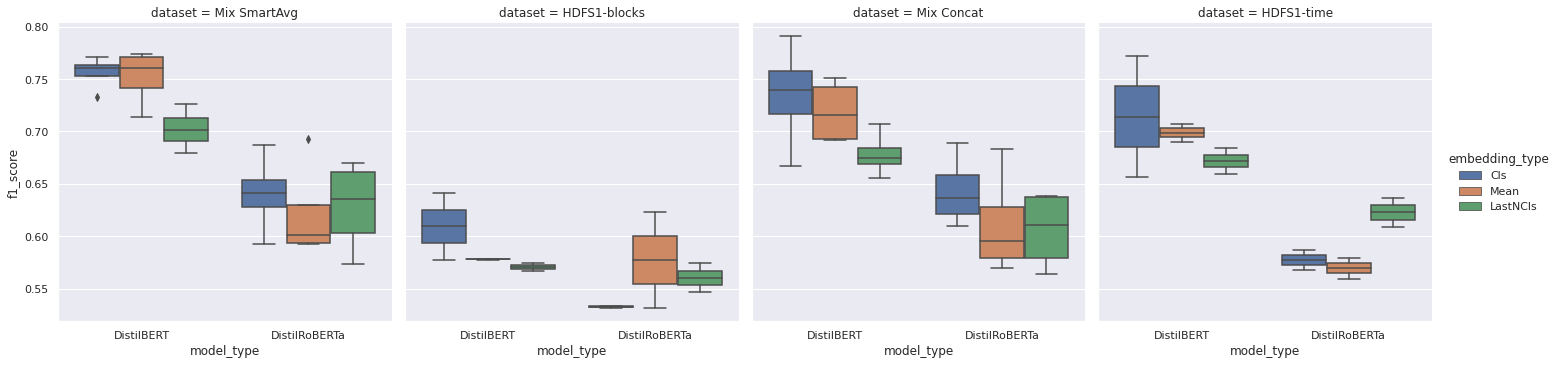

In [18]:
import matplotlib.pyplot as plt
# a = sns.catplot(x='embedding_type', y='f1_score', hue='model_type', col='dataset', kind='violin', split=True, inner="stick", cut=0, data=df2[(~(df2['model_type'] == 'fastText'))])
a = sns.catplot(x='model_type', y='f1_score', hue='embedding_type', col='dataset', kind='box', order=['DistilBERT', 'DistilRoBERTa'], hue_order=['Cls', 'Mean','LastNCls'], data=df2[(~(df2['model_type'] == 'fastText'))])

In [19]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 15):
    display(df2[(~(df2['model_type'] == 'fastText')) & ~(df2['dataset'].str.startswith('HDFS'))].sort_values(by=['model_type', 'embedding_type']))

,ranking,model_type,embedding_type,towers,epochs,dataset,precision,recall,f1_score,mcc_score,percentage_of_best,ds_type
10,11,DistilBERT,Cls,1T,5.0,Mix Concat,0.892003,0.642518,0.746980,0.751125,0.879608,Mix
11,2,DistilBERT,Cls,1T,3.0,Mix Concat,0.888231,0.712589,0.790774,0.790204,0.931178,Mix
16,13,DistilBERT,Cls,2T,5.0,Mix SmartAvg,0.874074,0.630641,0.732666,0.736134,0.862753,Mix
19,5,DistilBERT,Cls,1T,3.0,Mix SmartAvg,0.860380,0.698931,0.771298,0.769494,0.908243,Mix
29,8,DistilBERT,Cls,1T,5.0,Mix SmartAvg,0.874710,0.671615,0.759825,0.760494,0.894734,Mix
39,14,DistilBERT,Cls,2T,5.0,Mix Concat,0.837920,0.650831,0.732620,0.731706,0.862699,Mix
45,33,DistilBERT,Cls,2T,3.0,Mix Concat,0.840253,0.552850,0.666905,0.674189,0.785316,Mix
48,7,DistilBERT,Cls,2T,3.0,Mix SmartAvg,0.875483,0.672209,0.760497,0.761190,0.895525,Mix
1,15,DistilBERT,LastNCls,1T,3.0,Mix SmartAvg,0.875314,0.621140,0.726641,0.730992,0.855658,Mix
12,19,DistilBERT,LastNCls,1T,3.0,Mix Concat,0.851759,0.603919,0.706741,0.710336,0.832224,Mix


In [20]:
FIG_INCHES=4
HEIGHT_RATIO=0.9

# HDFS1

In [21]:
hdfs1_blocks_df = df2[(df2['dataset'] == 'HDFS1-blocks') & (df2['model_type'] != 'fastText')].copy()
hdfs1_blocks_df['epochs'] = hdfs1_blocks_df['epochs'].astype(int)
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    display(HTML(hdfs1_blocks_df.sort_values(by=['ranking']).to_html(index=False)))

ranking,model_type,embedding_type,towers,epochs,dataset,precision,recall,f1_score,mcc_score,percentage_of_best,ds_type
40,DistilBERT,Cls,2T,4,HDFS1-blocks,0.791630,0.539192,0.641469,0.645048,0.755364,HDFS1
46,DistilRoBERTa,Mean,1T,4,HDFS1-blocks,0.581109,0.672209,0.623348,0.612861,0.734025,HDFS1
59,DistilBERT,Mean,1T,4,HDFS1-blocks,0.974684,0.411520,0.578706,0.627386,0.681456,HDFS1
60,DistilBERT,Mean,2T,4,HDFS1-blocks,0.975989,0.410333,0.577759,0.626909,0.680342,HDFS1
61,DistilBERT,Cls,1T,4,HDFS1-blocks,0.980085,0.409145,0.577294,0.627367,0.679794,HDFS1
62,DistilBERT,LastNCls,1T,4,HDFS1-blocks,0.978541,0.406176,0.574066,0.624541,0.675993,HDFS1
63,DistilRoBERTa,LastNCls,2T,4,HDFS1-blocks,0.971671,0.407363,0.574059,0.623157,0.675984,HDFS1
67,DistilBERT,LastNCls,2T,4,HDFS1-blocks,0.953652,0.403207,0.566778,0.613865,0.667411,HDFS1
70,DistilRoBERTa,LastNCls,1T,4,HDFS1-blocks,0.961194,0.382423,0.547154,0.600121,0.644302,HDFS1
71,DistilRoBERTa,Cls,2T,4,HDFS1-blocks,0.995138,0.364608,0.533681,0.596595,0.628437,HDFS1


(0.5125278482157896, 0.6576818507976416)


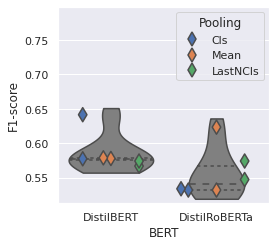

In [22]:
# ax = sns.stripplot(x='model_type', y='f1_score', hue='embedding_type', order=['DistilBERT', 'DistilRoBERTa'], hue_order=['Cls', 'Mean','LastNCls'], data=hdfs1_blocks_df, size=8, linewidth=2, dodge=True, marker="d")
# ax = sns.boxplot(x='model_type', y='f1_score', hue='embedding_type', order=['DistilBERT', 'DistilRoBERTa'], hue_order=['Cls', 'Mean','LastNCls'], data=hdfs1_blocks_df, showfliers = False)
import matplotlib.lines as mlines

HDFS1_YMIN, HDFS1_YMAX =(0.5125278482157896, 0.7989072132227987)

ax = sns.swarmplot(x='model_type', y='f1_score', hue='embedding_type', order=['DistilBERT', 'DistilRoBERTa'], hue_order=['Cls', 'Mean','LastNCls'],
                   data=hdfs1_blocks_df, size=10, linewidth=1.5, dodge=True, marker="d")
# ax = sns.boxplot(x='model_type', y='f1_score', hue='embedding_type', order=['DistilBERT', 'DistilRoBERTa'], hue_order=['Cls', 'Mean','LastNCls'], data=hdfs1_time_df, showfliers = False)
ax = sns.violinplot(x='model_type', y='f1_score', order=['DistilBERT', 'DistilRoBERTa'], data=hdfs1_blocks_df, showfliers = False, color='.5', inner='quartile', cut=0.5)

ax.set_xlabel("BERT")
ax.set_ylabel("F1-score")
legend = ax.legend(title='Pooling')
print(ax.get_ylim())
ax.set_ylim(ymin=HDFS1_YMIN, ymax=HDFS1_YMAX)
ax.legend(title='Pooling', handles=[mlines.Line2D([], [], color=hnd.get_facecolor()[0], marker='d', markeredgewidth=1.5,markeredgecolor='.3', linestyle='None', markersize=10) 
                                    for hnd in legend.legendHandles[:3]],
          labels=['Cls', 'Mean','LastNCls'])
fig = plt.gcf()
fig.set_size_inches(FIG_INCHES, HEIGHT_RATIO*FIG_INCHES)
# tikzplotlib.save("HDFS1BlocksF1Violinplot.tikz")
plt.tight_layout()
# plt.savefig("HDFS1BlocksF1Violinplot.pdf")

In [23]:
hdfs1_time_df = df2[(df2['dataset'] == 'HDFS1-time') & (df2['model_type'] != 'fastText')].copy()
hdfs1_time_df['epochs'] = hdfs1_time_df['epochs'].astype(int)
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    display(HTML(hdfs1_time_df.sort_values(by=['ranking']).to_html(index=False)))

ranking,model_type,embedding_type,towers,epochs,dataset,precision,recall,f1_score,mcc_score,percentage_of_best,ds_type
4,DistilBERT,Cls,2T,4,HDFS1-time,0.741794,0.805226,0.772210,0.765732,0.909317,HDFS1
18,DistilBERT,Mean,2T,4,HDFS1-time,0.844884,0.608076,0.707182,0.709802,0.832744,HDFS1
24,DistilBERT,Mean,1T,4,HDFS1-time,0.779940,0.618765,0.690066,0.686644,0.812589,HDFS1
27,DistilBERT,LastNCls,2T,4,HDFS1-time,0.832907,0.580166,0.683934,0.687796,0.805368,HDFS1
34,DistilBERT,LastNCls,1T,4,HDFS1-time,0.809318,0.557007,0.659866,0.663529,0.777027,HDFS1
36,DistilBERT,Cls,1T,4,HDFS1-time,0.782716,0.564727,0.656088,0.656527,0.772578,HDFS1
44,DistilRoBERTa,LastNCls,1T,4,HDFS1-time,0.643247,0.630641,0.636882,0.626072,0.749961,HDFS1
51,DistilRoBERTa,LastNCls,2T,4,HDFS1-time,0.825203,0.482185,0.608696,0.622870,0.716771,HDFS1
55,DistilRoBERTa,Cls,2T,4,HDFS1-time,0.917929,0.431710,0.587237,0.622853,0.691503,HDFS1
58,DistilRoBERTa,Mean,2T,4,HDFS1-time,0.929227,0.421021,0.579485,0.618957,0.682374,HDFS1


(0.5377845155420777, 0.7989072132227987)


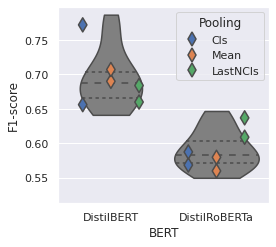

In [24]:
# ax = sns.stripplot(x='model_type', y='f1_score', hue='embedding_type', order=['DistilBERT', 'DistilRoBERTa'], hue_order=['Cls', 'Mean','LastNCls'], data=hdfs1_time_df, size=8, linewidth=2, dodge=True, marker="d")
# # ax = sns.boxplot(x='model_type', y='f1_score', hue='embedding_type', order=['DistilBERT', 'DistilRoBERTa'], hue_order=['Cls', 'Mean','LastNCls'], data=hdfs1_time_df, showfliers = False)
# ax = sns.boxplot(x='model_type', y='f1_score', order=['DistilBERT', 'DistilRoBERTa'], data=hdfs1_time_df, showfliers = False, color='.2', boxprops=dict(alpha=.3))

ax = sns.swarmplot(x='model_type', y='f1_score', hue='embedding_type', order=['DistilBERT', 'DistilRoBERTa'], hue_order=['Cls', 'Mean','LastNCls'], data=hdfs1_time_df, size=10, linewidth=1.5, dodge=True, marker="d")
ax = sns.violinplot(x='model_type', y='f1_score', order=['DistilBERT', 'DistilRoBERTa'], data=hdfs1_time_df, showfliers = False, color='.5', inner='quartile', cut=0.5)

ax.set_xlabel("BERT")
ax.set_ylabel("F1-score")
legend = ax.legend(title='Pooling')
ax.legend(title='Pooling', handles=[mlines.Line2D([], [], color=hnd.get_facecolor()[0], marker='d', markeredgewidth=1.5,markeredgecolor='.3', linestyle='None', markersize=10) 
                                    for hnd in legend.legendHandles[:3]],
          labels=['Cls', 'Mean','LastNCls'])
print(ax.get_ylim())
ax.set_ylim(ymin=HDFS1_YMIN, ymax=HDFS1_YMAX)
fig = plt.gcf()
fig.set_size_inches(FIG_INCHES, HEIGHT_RATIO*FIG_INCHES)
plt.tight_layout()
# ax.legend(title='Pooling', handles=legend.legendHandles[:3], labels=['Cls', 'Mean','LastNCls'])
# tikzplotlib.save("HDFS1TimeF1Swarmplot.tikz")
# plt.savefig("HDFS1TimeF1Violinplot.pdf")

# Mix

In [25]:
mix_concat_df = df2[(df2['dataset'] == 'Mix Concat') & (df2['model_type'] != 'fastText')].copy()
mix_concat_df['epochs'] = mix_concat_df['epochs'].astype(int)
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    display(HTML(mix_concat_df.sort_values(by=['ranking']).to_html(index=False)))

ranking,model_type,embedding_type,towers,epochs,dataset,precision,recall,f1_score,mcc_score,percentage_of_best,ds_type
2,DistilBERT,Cls,1T,3,Mix Concat,0.888231,0.712589,0.790774,0.790204,0.931178,Mix
9,DistilBERT,Mean,1T,5,Mix Concat,0.882212,0.653800,0.751023,0.753471,0.884369,Mix
11,DistilBERT,Cls,1T,5,Mix Concat,0.892003,0.642518,0.746980,0.751125,0.879608,Mix
12,DistilBERT,Mean,1T,3,Mix Concat,0.860979,0.647268,0.738983,0.740113,0.870191,Mix
14,DistilBERT,Cls,2T,5,Mix Concat,0.837920,0.650831,0.732620,0.731706,0.862699,Mix
19,DistilBERT,LastNCls,1T,3,Mix Concat,0.851759,0.603919,0.706741,0.710336,0.832224,Mix
21,DistilBERT,Mean,2T,3,Mix Concat,0.797068,0.613420,0.693289,0.691471,0.816384,Mix
23,DistilBERT,Mean,2T,5,Mix Concat,0.867384,0.574822,0.691429,0.699304,0.814193,Mix
25,DistilRoBERTa,Cls,2T,3,Mix Concat,0.805887,0.601544,0.688881,0.688571,0.811194,Mix
28,DistilRoBERTa,Mean,2T,3,Mix Concat,0.810106,0.590261,0.682927,0.683818,0.804182,Mix


(0.5388433155234316, 0.8159563876381315)


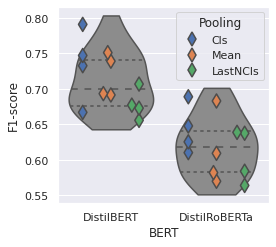

In [26]:
# ax = sns.stripplot(x='model_type', y='f1_score', hue='embedding_type', order=['DistilBERT', 'DistilRoBERTa'], hue_order=['Cls', 'Mean','LastNCls'], data=mix_concat_df, size=8, linewidth=2, dodge=True, marker="d")
# ax = sns.boxplot(x='model_type', y='f1_score', hue='embedding_type', order=['DistilBERT', 'DistilRoBERTa'], hue_order=['Cls', 'Mean','LastNCls'], data=mix_concat_df, showfliers = False)

ax = sns.swarmplot(x='model_type', y='f1_score', hue='embedding_type', order=['DistilBERT', 'DistilRoBERTa'], hue_order=['Cls', 'Mean','LastNCls'], data=mix_concat_df, size=10, linewidth=1.5, marker="d", dodge=True)
# ax = sns.boxplot(x='model_type', y='f1_score', hue='embedding_type', order=['DistilBERT', 'DistilRoBERTa'], hue_order=['Cls', 'Mean','LastNCls'], data=hdfs1_time_df, showfliers = False)
ax = sns.violinplot(x='model_type', y='f1_score', order=['DistilBERT', 'DistilRoBERTa'], data=mix_concat_df, showfliers = False, color='.55', inner='quartile', cut=0.5)
print(ax.get_ylim())
MIX_YMIN, MIX_YMAX = ax.get_ylim()

ax.set_xlabel("BERT")
ax.set_ylabel("F1-score")

# tikzplotlib.save("MixConcatF1Boxplot.tikz")
legend = ax.legend(title='Pooling')
ax.legend(title='Pooling', handles=[mlines.Line2D([], [], color=hnd.get_facecolor()[0], marker='d', markeredgewidth=1.5,markeredgecolor='.3', linestyle='None', markersize=10) 
                                    for hnd in legend.legendHandles[:3]],
          labels=['Cls', 'Mean','LastNCls'])

fig = plt.gcf()
fig.set_size_inches(FIG_INCHES, HEIGHT_RATIO*FIG_INCHES)
plt.tight_layout()
# plt.savefig("MixConcatF1Violinplot.pdf")

In [27]:
mix_smartavg_df = df2[(df2['dataset'] == 'Mix SmartAvg') & (df2['model_type'] != 'fastText')].copy()
mix_smartavg_df['epochs'] = mix_smartavg_df['epochs'].astype(int)
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    display(HTML(mix_smartavg_df.sort_values(by=['ranking']).to_html(index=False)))

ranking,model_type,embedding_type,towers,epochs,dataset,precision,recall,f1_score,mcc_score,percentage_of_best,ds_type
3,DistilBERT,Mean,1T,3,Mix SmartAvg,0.902613,0.676960,0.773668,0.776220,0.911035,Mix
5,DistilBERT,Cls,1T,3,Mix SmartAvg,0.860380,0.698931,0.771298,0.769494,0.908243,Mix
6,DistilBERT,Mean,1T,5,Mix SmartAvg,0.897233,0.673990,0.769752,0.772063,0.906424,Mix
7,DistilBERT,Cls,2T,3,Mix SmartAvg,0.875483,0.672209,0.760497,0.761190,0.895525,Mix
8,DistilBERT,Cls,1T,5,Mix SmartAvg,0.874710,0.671615,0.759825,0.760494,0.894734,Mix
10,DistilBERT,Mean,2T,3,Mix SmartAvg,0.856816,0.668052,0.750751,0.750267,0.884048,Mix
13,DistilBERT,Cls,2T,5,Mix SmartAvg,0.874074,0.630641,0.732666,0.736134,0.862753,Mix
15,DistilBERT,LastNCls,1T,3,Mix SmartAvg,0.875314,0.621140,0.726641,0.730992,0.855658,Mix
16,DistilBERT,Mean,2T,5,Mix SmartAvg,0.855721,0.612827,0.714187,0.717413,0.840992,Mix
17,DistilBERT,LastNCls,2T,3,Mix SmartAvg,0.829482,0.618171,0.708404,0.708914,0.834183,Mix


(0.5500022947407909, 0.7945729581067246)


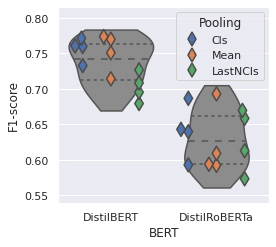

In [28]:
# OLD
# ax = sns.stripplot(x='model_type', y='f1_score', hue='embedding_type', order=['DistilBERT', 'DistilRoBERTa'], hue_order=['Cls', 'Mean','LastNCls'], data=mix_smartavg_df, size=8, linewidth=2, dodge=True, marker="d")
# ax = sns.boxplot(x='model_type', y='f1_score', hue='embedding_type', order=['DistilBERT', 'DistilRoBERTa'], hue_order=['Cls', 'Mean','LastNCls'], data=mix_smartavg_df, showfliers = False)
# ax.set_xlabel("BERT")
# ax.set_ylabel("F1-score")
# legend = ax.legend()
# ax.legend(title='Pooling', handles=legend.legendHandles[:3], labels=['Cls', 'Mean','LastNCls'])
# tikzplotlib.save("MixSmartAvgF1Boxplot.tikz")
ax = sns.swarmplot(x='model_type', y='f1_score', hue='embedding_type', order=['DistilBERT', 'DistilRoBERTa'], hue_order=['Cls', 'Mean','LastNCls'], data=mix_smartavg_df, size=10, linewidth=1.5, marker="d", dodge=True)
ax = sns.violinplot(x='model_type', y='f1_score', order=['DistilBERT', 'DistilRoBERTa'], data=mix_smartavg_df, showfliers = False, color='.55', inner='quartile', cut=0.5)
print(ax.get_ylim())
ax.set_ylim(ymin=MIX_YMIN, ymax=MIX_YMAX)

ax.set_xlabel("BERT")
ax.set_ylabel("F1-score")

legend = ax.legend(title='Pooling')
ax.legend(title='Pooling', handles=[mlines.Line2D([], [], color=hnd.get_facecolor()[0], marker='d', markeredgewidth=1.5,markeredgecolor='.3', linestyle='None', markersize=10) 
                                    for hnd in legend.legendHandles[:3]],
          labels=['Cls', 'Mean','LastNCls'])

fig = plt.gcf()
fig.set_size_inches(FIG_INCHES, HEIGHT_RATIO*FIG_INCHES)
plt.tight_layout()
# plt.savefig("MixSmartAvgF1Violinplot.pdf")

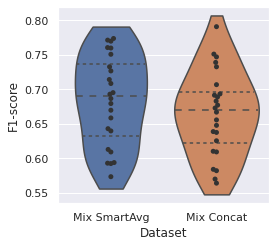

In [29]:
# ax = sns.violinplot(x='model_type', y='f1_score', hue='dataset', order=['DistilBERT', 'DistilRoBERTa'], data=df2[df2['dataset'].str.startswith('Mix')], inner='quartile')
ax = sns.violinplot(x='dataset', y='f1_score', order=['Mix SmartAvg', 'Mix Concat'], data=df2[df2['dataset'].str.startswith('Mix')], inner='quartile', cut=0.5)
ax = sns.swarmplot(x='dataset', y='f1_score', order=['Mix SmartAvg', 'Mix Concat'], data=df2[df2['dataset'].str.startswith('Mix')], color='.2')
ax.set_xlabel("Dataset")
ax.set_ylabel("F1-score")
fig = plt.gcf()
fig.set_size_inches(FIG_INCHES, HEIGHT_RATIO*FIG_INCHES)
plt.tight_layout()
# tikzplotlib.save("MixSmartAvgF1Boxplot.tikz")

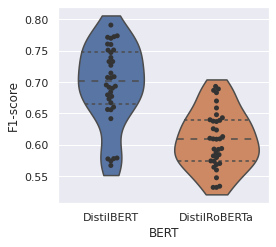

In [30]:
ax = sns.violinplot(x='model_type', y='f1_score', order=['DistilBERT', 'DistilRoBERTa'], data=df2[(df2['model_type'] != 'fastText')], inner='quartile', cut=0.5)
ax = sns.swarmplot(x='model_type', y='f1_score', order=['DistilBERT', 'DistilRoBERTa'], data=df2[(df2['model_type'] != 'fastText')], color='.2')
ax.set_xlabel("BERT")
ax.set_ylabel("F1-score")
fig = plt.gcf()
fig.set_size_inches(FIG_INCHES, HEIGHT_RATIO*FIG_INCHES)
plt.tight_layout()
# plt.savefig("DistilBERTvsDistilRoBERTa.pdf")

(0.49586281311981145, 0.8267336314408145)


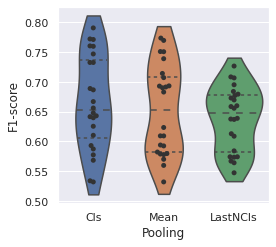

In [31]:
ax = sns.violinplot(x='embedding_type', y='f1_score', order=['Cls', 'Mean','LastNCls'], data=df2[df2['model_type']!= 'fastText'], inner='quartile', cut=0.5)
ax = sns.swarmplot(x='embedding_type', y='f1_score', order=['Cls', 'Mean','LastNCls'], data=df2[df2['model_type']!= 'fastText'], color='.2')
ax.set_xlabel("Pooling")
ax.set_ylabel("F1-score")
print(ax.get_ylim())
fig = plt.gcf()
fig.set_size_inches(FIG_INCHES, HEIGHT_RATIO*FIG_INCHES)
plt.tight_layout()
# plt.savefig("PoolingComparisonAll.pdf")

(0.538726174366256, 0.8238256880824082)


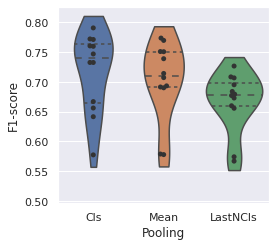

In [32]:
ax = sns.violinplot(x='embedding_type', y='f1_score', order=['Cls', 'Mean','LastNCls'], data=df2[df2['model_type']== 'DistilBERT'], inner='quartile', cut=0.5)
ax = sns.swarmplot(x='embedding_type', y='f1_score', order=['Cls', 'Mean','LastNCls'], data=df2[df2['model_type']== 'DistilBERT'], color='.2')
ax.set_xlabel("Pooling")
ax.set_ylabel("F1-score")
print(ax.get_ylim())
ax.set_ylim(ymin=0.49586281311981145, ymax=0.8267336314408145)
fig = plt.gcf()
fig.set_size_inches(FIG_INCHES, HEIGHT_RATIO*FIG_INCHES)
plt.tight_layout()
# plt.savefig("PoolingComparisonDistilBERT.pdf")

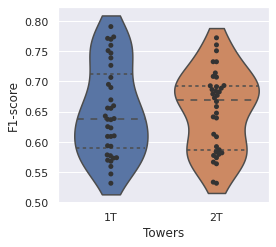

In [33]:
ax = sns.violinplot(x='towers', y='f1_score', order=['1T', '2T'], data=df2[(df2['model_type'] != 'fastText')], inner='quartile', cut=0.5)
ax = sns.swarmplot(x='towers', y='f1_score', order=['1T', '2T'], data=df2[(df2['model_type'] != 'fastText')], color='.2')
ax.set_xlabel("Towers")
ax.set_ylabel("F1-score")
fig = plt.gcf()
fig.set_size_inches(FIG_INCHES, HEIGHT_RATIO*FIG_INCHES)
plt.tight_layout()
# plt.savefig("TowersComparisonAll.pdf")

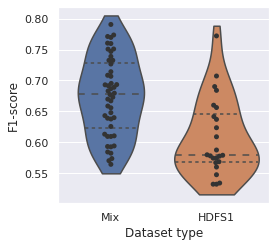

In [34]:
ax = sns.violinplot(x='ds_type', y='f1_score', order=['Mix', 'HDFS1'], data=df2[(df2['model_type'] != 'fastText')], inner='quartile', cut=0.5)
ax = sns.swarmplot(x='ds_type', y='f1_score', order=['Mix', 'HDFS1'], data=df2[(df2['model_type'] != 'fastText')], color='.2')
ax.set_xlabel("Dataset type")
ax.set_ylabel("F1-score")
fig = plt.gcf()
fig.set_size_inches(FIG_INCHES, HEIGHT_RATIO*FIG_INCHES)
plt.tight_layout()
# plt.savefig("DatasetTypeComparisonAll.pdf")

#### Test truncation quality
null: SmartAvg results in smaller F1

alternative : SmartAvg results in greater F1

In [35]:
mix_sa_f1 = mix_smartavg_df.sort_values(by=['model_type', 'embedding_type', 'towers', 'epochs'])['f1_score']
mix_co_f1 = mix_concat_df.sort_values(by=['model_type', 'embedding_type', 'towers', 'epochs'])['f1_score']

In [36]:
scipy.stats.wilcoxon(mix_sa_f1, mix_co_f1, alternative='greater')

WilcoxonResult(statistic=243.0, pvalue=0.003940302036674363)

#### Test that DistilRoBERTa on Mix better than HDFS1 everything

null: DistilRoBERTa on Mix lower average f1 score than all encoders on HDFS1

alternative: DistilRoBERTa on Mix higher average f1 score than all encoders on HDFS1

In [37]:
hdfs_f1 = df2[df2['dataset'].str.startswith('HDFS1') & (df2['model_type'] != 'fastText')]['f1_score']

In [38]:
rob_mix_f1 = df2[df2['dataset'].str.startswith('Mix') & (df2['model_type'] == 'DistilRoBERTa')]['f1_score']

In [39]:
scipy.stats.mannwhitneyu(rob_mix_f1, hdfs_f1, alternative='greater')

MannwhitneyuResult(statistic=373.0, pvalue=0.0407185454516917)

In [40]:
hdfs_f1 = df2[df2['dataset'].str.startswith('HDFS1-t') & (df2['model_type'] != 'fastText')]['f1_score']
mix_f1 = df2[df2['dataset'].str.startswith('Mix')]['f1_score']
scipy.stats.mannwhitneyu(mix_f1, hdfs_f1, alternative='greater')

MannwhitneyuResult(statistic=374.0, pvalue=0.05704364755504687)

In [41]:
scipy.stats.ttest_ind(hdfs_f1, mix_f1, equal_var=False)

Ttest_indResult(statistic=-1.5375736508471072, pvalue=0.14293614920997727)

#### DistilRoBERTa mean better than distilroberta cls

In [42]:
roberta_mean_df = df2[(df2['model_type'] == 'DistilRoBERTa') & (df2['embedding_type'] == 'Mean')].sort_values(by=['dataset', 'towers', 'epochs'])
roberta_cls_df = df2[(df2['model_type'] == 'DistilRoBERTa') & (df2['embedding_type'] == 'Cls')].sort_values(by=['dataset', 'towers', 'epochs'])
scipy.stats.wilcoxon(roberta_mean_df['f1_score'], roberta_cls_df['f1_score'], alternative='greater')

WilcoxonResult(statistic=22.0, pvalue=0.9088308229096158)

#### Is there any difference between pooling methods

In [43]:
mean_df = df2[(df2['embedding_type'] == 'Mean')].sort_values(by=['model_type', 'dataset', 'towers', 'epochs'])
cls_df = df2[(df2['embedding_type'] == 'Cls')].sort_values(by=['model_type', 'dataset', 'towers', 'epochs'])
lastNCls_df = df2[(df2['embedding_type'] == 'LastNCls')].sort_values(by=['model_type', 'dataset', 'towers', 'epochs'])

In [44]:
scipy.stats.friedmanchisquare(mean_df['f1_score'], cls_df['f1_score'], lastNCls_df['f1_score'])

FriedmanchisquareResult(statistic=3.5833333333333144, pvalue=0.1666821344779481)

#### Difference between pooling for DistilBERT only

In [45]:
mean_df = df2[(df2['embedding_type'] == 'Mean') & (df2['model_type']== 'DistilBERT')].sort_values(by=['model_type', 'dataset', 'towers', 'epochs'])
cls_df = df2[(df2['embedding_type'] == 'Cls') & (df2['model_type']== 'DistilBERT')].sort_values(by=['model_type', 'dataset', 'towers', 'epochs'])
lastNCls_df = df2[(df2['embedding_type'] == 'LastNCls') & (df2['model_type']== 'DistilBERT')].sort_values(by=['model_type', 'dataset', 'towers', 'epochs'])
scipy.stats.friedmanchisquare(mean_df['f1_score'], cls_df['f1_score'], lastNCls_df['f1_score'])

FriedmanchisquareResult(statistic=12.666666666666657, pvalue=0.0017761035457343876)

#### Is Two Tower better in general?

In [49]:
onetower_df = df2[(df2['model_type'] != 'fastText') & (df2['towers'] == '1T')].sort_values(by=['model_type', 'embedding_type', 'dataset', 'epochs'])
twotower_df = df2[(df2['model_type'] != 'fastText') & (df2['towers'] == '2T')].sort_values(by=['model_type', 'embedding_type', 'dataset', 'epochs'])
scipy.stats.wilcoxon(twotower_df['f1_score'], onetower_df['f1_score'], alternative='two-sided')

WilcoxonResult(statistic=332.0, pvalue=0.9874652904648469)

#### Is DistilBERT better than DistilRoBERTa in general?

In [47]:
distilbert_df = df2[(df2['model_type'] == 'DistilBERT')].sort_values(by=['embedding_type', 'towers', 'dataset', 'epochs'])
roberta_df = df2[(df2['model_type'] == 'DistilRoBERTa')].sort_values(by=['embedding_type', 'towers', 'dataset', 'epochs'])
scipy.stats.wilcoxon(distilbert_df['f1_score'], roberta_df['f1_score'], alternative='greater')

WilcoxonResult(statistic=653.0, pvalue=2.48608063883089e-07)

#### Is Mix better than HDFS1?

In [48]:
hdfs_df = df2[df2['dataset'].str.startswith('HDFS1') & (df2['model_type'] != 'fastText')].sort_values(by=['model_type','embedding_type', 'towers', 'dataset', 'epochs'])
mix_df = df2[df2['dataset'].str.startswith('Mix') & (df2['model_type'] != 'fastText')].sort_values(by=['model_type','embedding_type', 'towers', 'dataset', 'epochs'])
scipy.stats.mannwhitneyu(mix_df['f1_score'], hdfs_df['f1_score'], alternative='greater')

MannwhitneyuResult(statistic=906.0, pvalue=4.1414895957924666e-05)